In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "github_assistant"

In [4]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
import os
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


prompt = ChatPromptTemplate.from_messages(
    [
        #         (
        #             "system",
        #             """You are an AI programming assistant. When asked for your name, you must respond with 'SeanPilot'. Follow the user's requirements carefully & to the letter. For questions not related to software development, simply give a reminder that you are an AI programming assistant. Keep your answers short and impersonal.
        # You should help the user to the best of your ability. If there's a tool you need, feel free to call it and use it.
        # Start by breaking down your users' needs as finely as possible, and choose a tool to address each need.
        # Answer in Korean.""",
        #         ),
        (
            "system",
            """You're an AI programming assistant. You need to help users to the best of your ability.
Your task is to figure out the overall structure of the project. Especially with complex projects, you'll want to keep track of how each file is related to the others.
You should follow these steps
1. Categorize and plan your users' needs in as much detail as possible. If necessary, choose a tool to address each need.
2. process the plan sequentially.

Answer in Korean.
""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


def get_directory_tree_str(root_dir):
    directory_structure = "<directory_structure>\n"
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, "").count(os.sep)
        indent = " " * 4 * (level)
        directory_structure += f"{indent}{os.path.basename(root)}/\n"
        sub_indent = " " * 4 * (level + 1)
        for f in files:
            directory_structure += f"{sub_indent}{f}\n"
    directory_structure += "</directory_structure>"
    return directory_structure


@tool
def get_directory_structure(root_dir: str) -> str:
    """Get the directory structure of the project. If you need to check the directory structure, use this tool."""
    return get_directory_tree_str(root_dir)


@tool
def get_file_contents(file_path: str) -> str:
    """Get the contents of a file. If you need to check the contents of each file, use this tool"""

    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read()
        # 파이썬 파일인 경우에만 코드 블록으로 감싸기
        if file_path.endswith((".py", ".ipynb")):
            return f"```python\n{content}\n```"
    return content


llm = ChatOpenAI(model="gpt-4o", temperature=0)

tools = [get_directory_structure, get_file_contents]

llm = llm.bind_tools(tools)

chain = prompt | llm

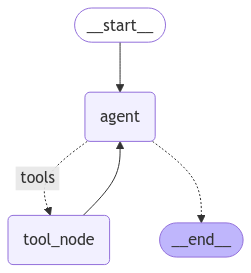

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver


def summary_agent(state: State) -> State:
    messages = state["messages"]
    print("==================== [MESSAGES] ====================")
    print(messages)
    response = chain.invoke({"messages": messages})
    return {"messages": [response]}


tool_node = ToolNode(tools=tools)

work_flow = StateGraph(State)
work_flow.add_node("agent", summary_agent)
work_flow.add_node("tool_node", tool_node)

work_flow.add_edge(START, "agent")
work_flow.add_edge("tool_node", "agent")
work_flow.add_conditional_edges(
    "agent",
    tools_condition,  #! 변경 (return Literal["tools", "__end__"])
    {"tools": "tool_node", "__end__": END},
)

memory = MemorySaver()
graph = work_flow.compile(checkpointer=memory)

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from langchain_teddynote.messages import stream_graph

config = {"recursion_limit": 10, "configurable": {"thread_id": "abc"}}

inputs = {"messages": [("user", "main.py 파일을 자세하게 설명해주세요.")]}

# stream_graph(graph, inputs, config)

for event in graph.stream(
    input=inputs,
    config=config,
    stream_mode="values",  # 각 노드의 출력 상태
    # interrupt_before=["tool_node"],  # tool_node로 가기 전에 멈추기!
):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")

        print(value[-1].pretty_print())


[ messages ]

================================ Human Message =================================

main.py 파일을 자세하게 설명해주세요.
None
==================== [MESSAGES] ====================
[HumanMessage(content='전체 프로젝트 로직에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='49be0159-ec68-47f2-b7c7-65513c6e32a0'), AIMessage(content='프로젝트의 전체 로직을 이해하기 위해서는 먼저 프로젝트의 디렉토리 구조를 파악하고, 각 파일의 내용을 확인하여 파일 간의 관계를 분석해야 합니다. 이를 통해 프로젝트의 전반적인 구조와 흐름을 이해할 수 있습니다. 다음은 이를 위한 단계별 계획입니다.\n\n1. **디렉토리 구조 파악**: 프로젝트의 루트 디렉토리에서 시작하여 전체 디렉토리 구조를 확인합니다. 이를 통해 프로젝트가 어떤 파일과 폴더로 구성되어 있는지, 각 파일이 어디에 위치하는지를 알 수 있습니다.\n\n2. **파일 내용 확인**: 각 파일의 내용을 확인하여 파일이 어떤 역할을 하는지, 어떤 기능을 구현하고 있는지를 파악합니다. 특히, 주요 파일(예: `main` 파일, 설정 파일, 주요 모듈 파일 등)의 내용을 중점적으로 확인합니다.\n\n3. **파일 간 관계 분석**: 파일 간의 의존성이나 호출 관계를 분석합니다. 이를 통해 각 파일이 어떻게 상호작용하는지, 어떤 파일이 다른 파일을 호출하거나 참조하는지를 이해할 수 있습니다.\n\n4. **전체 로직 설명**: 위의 정보를 바탕으로 프로젝트의 전체 로직을 설명합니다. 프로젝트의 주요 기능, 데이터 흐름, 모듈 간의 상호작용 등을 종합적으로 설명합니다.\n\n이제 첫 번째 단계로 프로젝트의 디렉토리 구조를 확인하겠습니다. 이를 위해 `get_direc

In [19]:
state = graph.get_state(config)

In [20]:
state.values

{'messages': [HumanMessage(content='전체 프로젝트 로직에 대해 설명해주세요.', additional_kwargs={}, response_metadata={}, id='cfb41c39-66b3-4cc9-a8f8-6f371885db01'),
  AIMessage(content='프로젝트의 전체 로직을 설명하기 위해서는 프로젝트의 디렉토리 구조와 각 파일의 내용을 확인해야 합니다. 우선 프로젝트의 디렉토리 구조를 확인하겠습니다. 어느 디렉토리의 구조를 확인할까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 221, 'total_tokens': 276, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff092ab25e', 'finish_reason': 'stop', 'logprobs': None}, id='run-80a001bf-9a0a-4e0e-a9c4-4d74083dc412-0', usage_metadata={'input_tokens': 221, 'output_tokens': 55, 'total_tokens': 276, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(conten